In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib as plt
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from kerastuner.tuners import Hyperband
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
plt.rcParams["figure.figsize"] = (20,10)

In [31]:
import os
print(os.getcwd())

C:\Users\Amin y Lubna


# Data cleansing
First 16 rows indicate geoposition (longitude,latitude and altitude).
That's the reason we use the skiprws parameter
The last row explain the variables, that's the reason we use the nrow parameter (to avoid using the last csv rows)
We have to use parse-dates and set the dates as index, we are working with time series

In [30]:
rows_to_skip=16
rows_to_read=8760

df=pd.read_csv('TMYPalma.csv',skiprows=rows_to_skip,nrows=rows_to_read,parse_dates=['time(UTC)'],index_col='time(UTC)')


FileNotFoundError: [Errno 2] No such file or directory: 'TMYPalma.csv'

PVGIS uses a non-standar data format, so we have to set a new format manually.
To improve our EDA and the posterior model, we will generate 2 new features (month and hour).
On the other side, PVGIS dataset has data from every month. But the data has not been taken in the same year, for example, the data from january can be from 2010 and the data from february can be from 2006. To get some continuity on the data and make a better analisys we set all the data to the year 2014.

In [17]:
df.index=pd.to_datetime(df.index, format='%Y%m%d:%H%M')
df.index = df.index.map(lambda x: x.replace(year=2014))



NameError: name 'df' is not defined

# Feature engineering
As we said before we will generate 2 new features 'Month' and 'Hour'. We think that the hour and the month are two major factors in the solar irradiance.

In [ ]:
df['Hour']=df.index.hour
df['Month']=df.index.month

# Data Analysis
Ahora analizaré las correlaciones existentes entre las variables que componen el modelo, en el caso de haber fuertes correlaciones eliminaremos alguna de las variables correlacionadas con tal de simplificar el modelo.

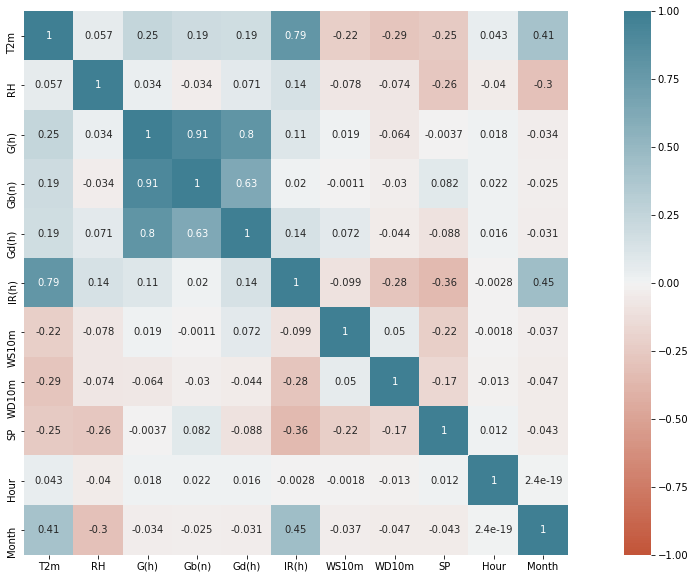

In [5]:
corr = df.corr()
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

Como era de esperar G(h), Gb(n) y Gd(h) estan altamente correlacionadas por lo que podemos eliminar las variables Gb(n) y Gd(h)

Evolución de la radiación global (hora) a lo largo del año

<AxesSubplot:xlabel='time(UTC)', ylabel='G(h)'>

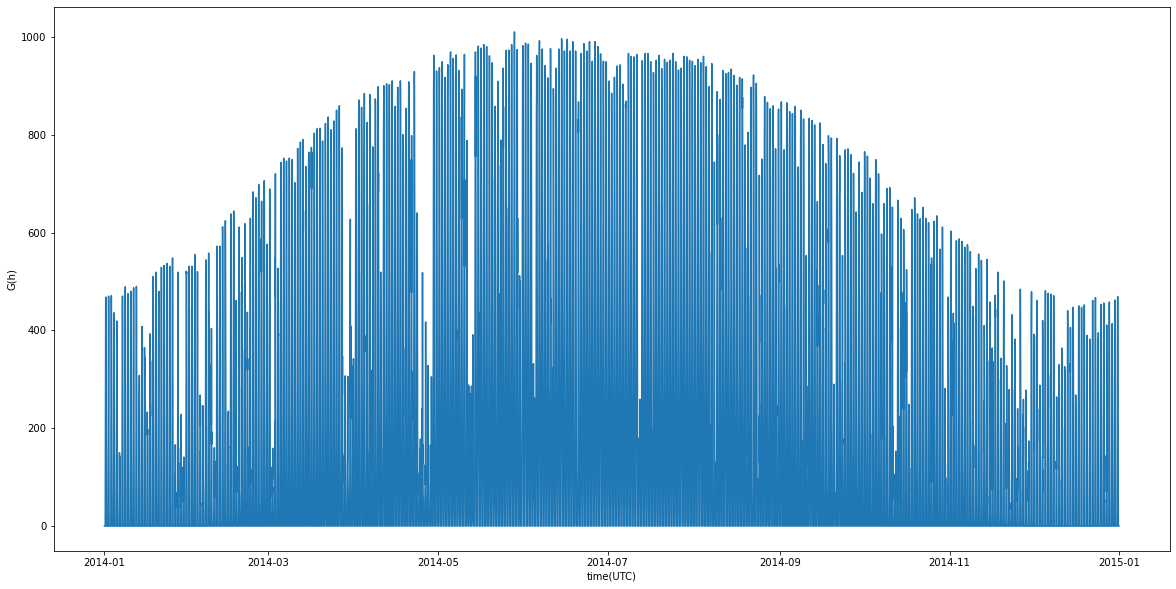

In [7]:
sns.lineplot(x=df.index,y='G(h)',data=df)


Evolución de la radiación global (día) a lo largo del año

<AxesSubplot:xlabel='time(UTC)', ylabel='G(h)'>

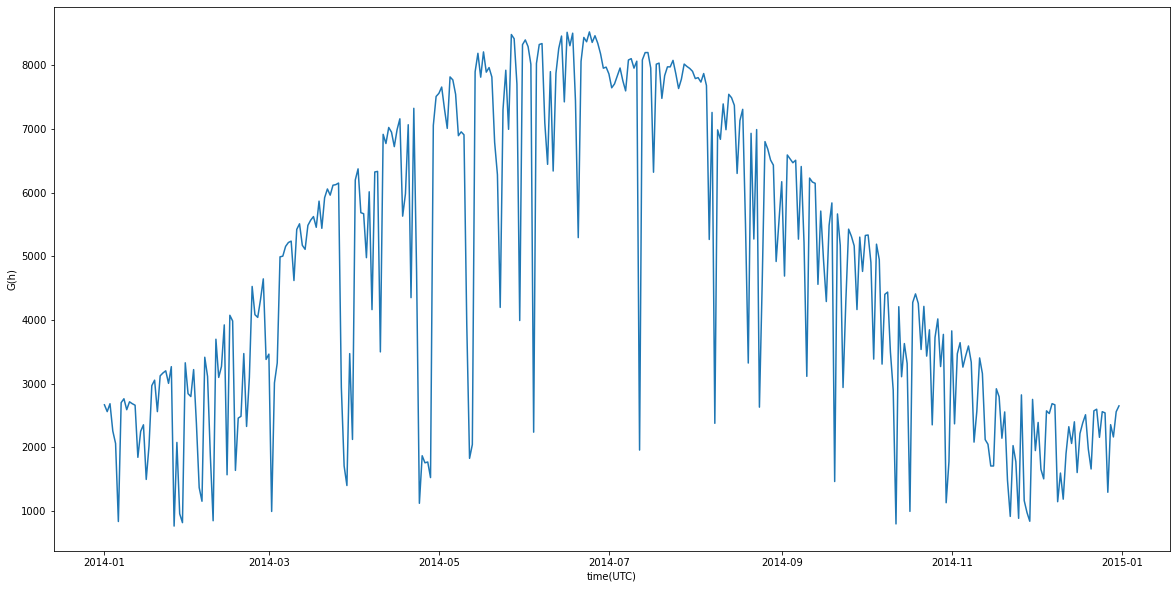

In [8]:
df_by_day=df.resample('D').sum()
sns.lineplot(x=df_by_day.index,y='G(h)',data=df_by_day)


Evolución de la radiación global (mes) a lo largo del año

<AxesSubplot:xlabel='time(UTC)', ylabel='G(h)'>

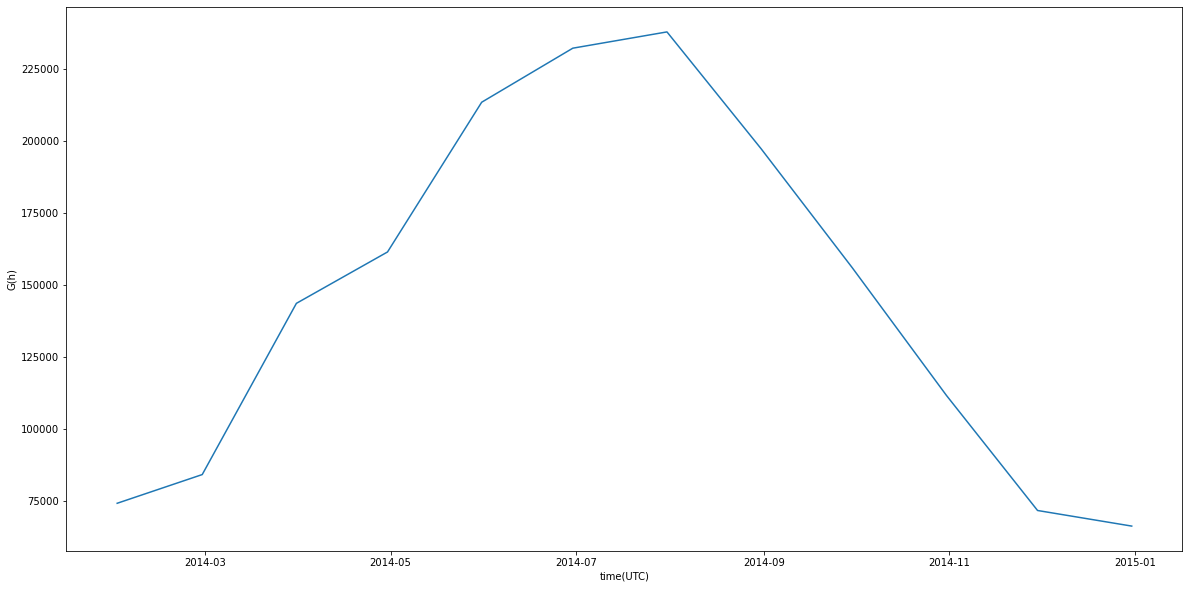

In [9]:
df_by_month=df.resample('M').sum()
sns.lineplot(x=df_by_month.index,y='G(h)',data=df_by_month)


Distribución de la radiación solar a lo largo del día

<AxesSubplot:xlabel='Hour', ylabel='G(h)'>

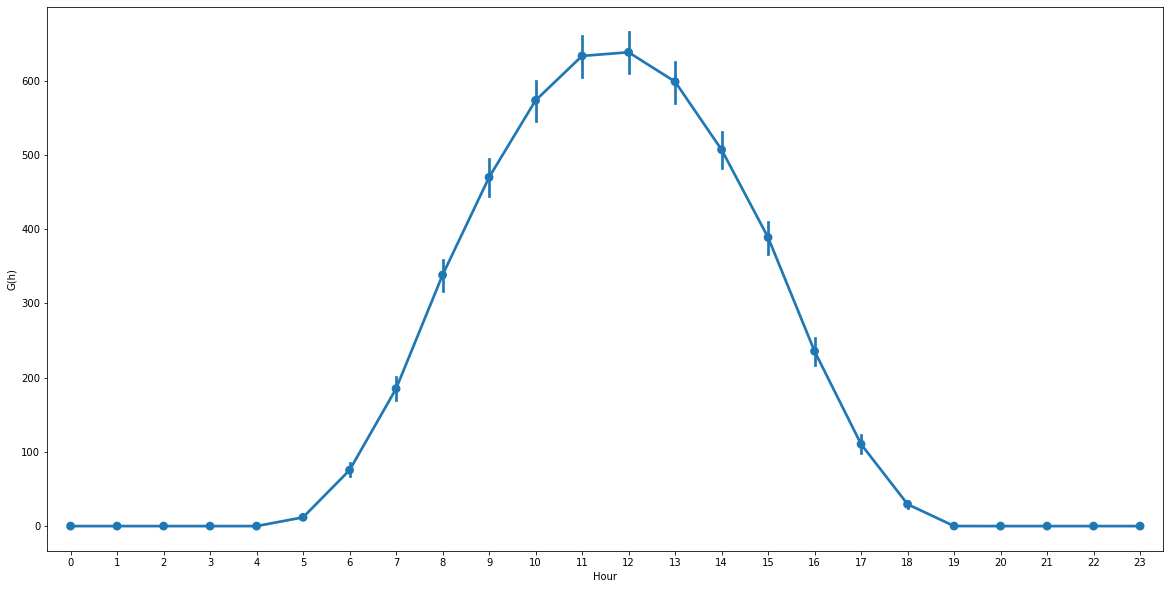

In [10]:
sns.pointplot(data=df,x='Hour',y='G(h)')

Distribución de la radiación solar durante los meses del año

<AxesSubplot:xlabel='Month', ylabel='G(h)'>

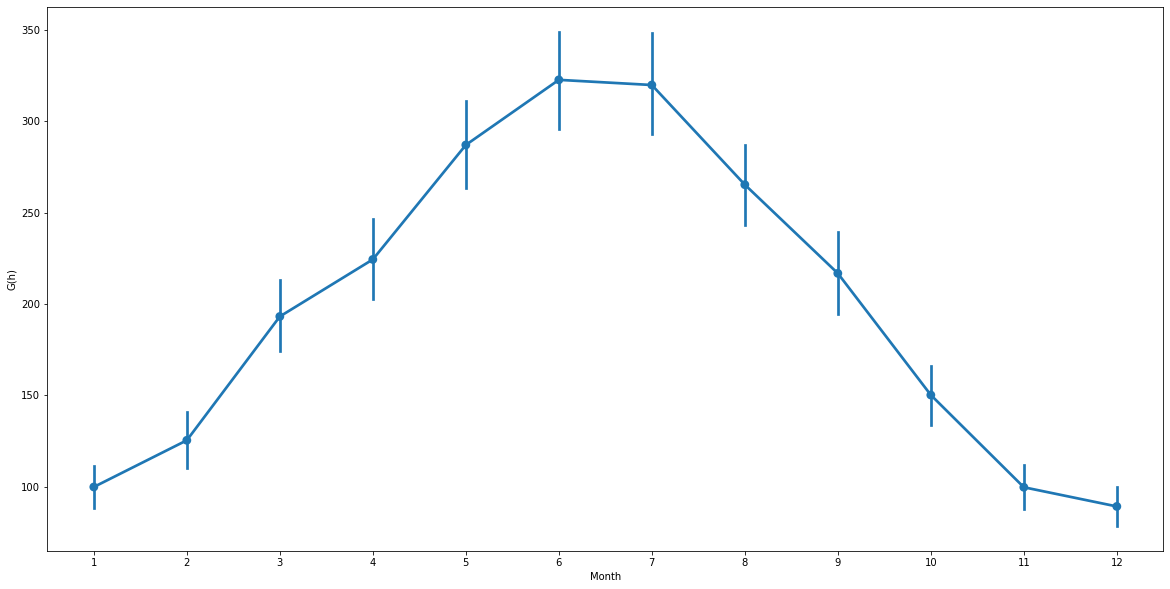

In [11]:
sns.pointplot(data=df,x='Month',y='G(h)')

In [12]:
#Comprabamos que los niveles de radiación medidos son inferios al límite teorico (la radiación solar en la superficie de la atmosfera)
df

,T2m,RH,G(h),Gb(n),Gd(h),IR(h),WS10m,WD10m,SP,Hour,Month
time(UTC),,,,,,,,,,,
2014-01-01 00:00:00,16.00,81.66,0.0,-0.0,0.0,310.15,2.56,284.0,102252.0,0,1
2014-01-01 01:00:00,15.97,82.42,0.0,-0.0,0.0,310.61,2.49,281.0,102228.0,1,1
2014-01-01 02:00:00,15.93,83.18,0.0,-0.0,0.0,311.06,2.41,278.0,102205.0,2,1
2014-01-01 03:00:00,15.89,83.94,0.0,-0.0,0.0,311.52,2.34,281.0,102218.0,3,1
2014-01-01 04:00:00,15.85,84.70,0.0,-0.0,0.0,311.97,2.26,284.0,102232.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,16.19,77.86,0.0,-0.0,0.0,307.88,2.94,301.0,102278.0,19,12
2014-12-31 20:00:00,16.15,78.62,0.0,-0.0,0.0,308.33,2.86,302.0,102295.0,20,12
2014-12-31 21:00:00,16.11,79.38,0.0,-0.0,0.0,308.79,2.79,297.0,102288.0,21,12


In [13]:
solar_constant=1362
df.drop(df[df["G(h)"]>=solar_constant].index,inplace=True)




In [14]:
train_size=int(len(df)*0.9)
test_size=len(df)-train_size
train_data,test_data=df.iloc[0:train_size],df.iloc[train_size:len(df)]



In [15]:
def create_dataset(dataset,number_steps):
    dataX, dataY = [], []
    for i in range(len(dataset)-number_steps-1):
        a = dataset[i:(i+number_steps), :]
        dataX.append(a)
        dataY.append(dataset[i + number_steps, 2])
    return np.array(dataX), np.array(dataY)

In [16]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('layer_1_neurons',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(hp.Float('Dropout_1_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_2_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [17]:
f_columns=['T2m','RH','Gb(n)','Gd(h)','IR(h)','WS10m','WD10m','SP','Hour','Month']
t_column=['G(h)']

In [18]:
#to avoid info about the test to leak towards our model, we will transform the train and the test in diferent steps
scaler=MinMaxScaler()
scaler_features=scaler.fit(train_data[f_columns].to_numpy())
scaler_target=scaler.fit(train_data[t_column].to_numpy())
X_train_scaled=scaler_features.transform(train_data[f_columns].to_numpy())
Y_train_scaled=scaler_target.transform(train_data[t_column].to_numpy())
X_test_scaled=scaler_features.transform(test_data[f_columns].to_numpy())
Y_test_scaled=scaler_target.transform(test_data[t_column].to_numpy())
steps=24
X_train,Y_train=create_dataset(X_train_scaled,steps)
X_test,Y_test=create_dataset(X_test_scaled,steps)
print(X_train.shape)


(7859, 24, 10)


In [71]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=50,
        executions_per_trial=5
        )
tuner.search(
        x=X_train,
        y=Y_train,
        epochs=20,
        batch_size=64,
        validation_data=(X_test,Y_test)
)

Trial 50 Complete [00h 30m 48s]
mse: 0.01602794844657183

Best mse So Far: 0.013852776400744915
Total elapsed time: 23h 28m 35s
INFO:tensorflow:Oracle triggered exit


In [137]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(X_test, Y_test)

27/27 [==============================] - 5s 110ms/step - loss: 0.0153 - mse: 0.0153


In [138]:
Y_train_inv=scaler_target.inverse_transform(Y_train.reshape(1,-1))
Y_pred_inv=scaler_target.inverse_transform(Y_pred_test)
Y_test_inv=scaler_target.inverse_transform(Y_test.reshape(1,-1))

In [1]:
plt.pyplot.plot(Y_test_inv.flatten(),marker='.',label='Reales')
plt.pyplot.plot(Y_pred_inv.flatten(),'r',label='Prediccion')
plt.pyplot.legend()

NameError: name 'plt' is not defined

In [144]:
best_model.save('C:\\Users\\Amin y Lubna\\Desktop\\Escritorio Virtual\\Carrera Amin\\1.TFG\\Informacion\\Modelo1.h5')

In [5]:
pyversion executable

In [3]:
keras.models.load_model('C:\\Users\\Amin y Lubna\\Desktop\\Escritorio Virtual\\Carrera Amin\\1.TFG\\Informacion\\Modelo1.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 352)           511104    
_________________________________________________________________
dropout (Dropout)            (None, 24, 352)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 384)               1132032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 385       
Total params: 1,643,521
Trainable params: 1,643,521
Non-trainable params: 0
_________________________________________________________________


In [19]:
type(X_test_scaled)

numpy.ndarray